In [1]:
import os
import h5py 
import numpy as np
from tqdm.auto import trange
import astropy.table as aTable

from astropy import units as U
from astropy.cosmology import Planck13

In [2]:
from provabgs import models as Models
from speclite import filters as specFilter

In [3]:
# -- plotting -- 
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

In [4]:
dat_dir = '/tigress/chhahn/provabgs/svda'

In [5]:
bgs = aTable.Table.read(os.path.join(dat_dir, 'BGS_BRIGHT_clustering.sv3.logM.hdf5'))
has_posterior = (bgs['zmax'].data != -999.) & (bgs['Z'].data < 0.2)
bgs = bgs[has_posterior]
print('%i galaxies' % len(bgs))

70355 galaxies


(6.5, 13.0)

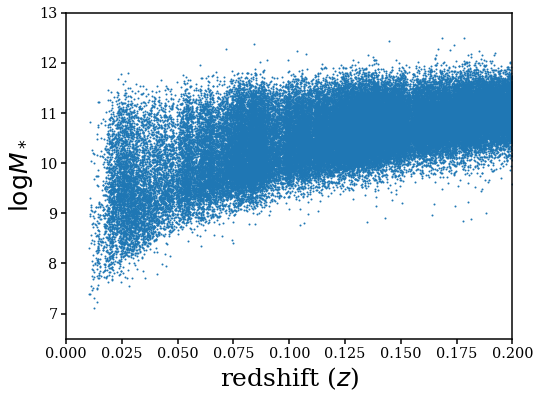

In [7]:
fig = plt.figure(figsize=(8,6))
sub = fig.add_subplot(111)
sub.scatter(bgs['Z'].data, bgs['theta_bf'].data[:,0], c='C0', s=1)
sub.set_xlabel(r"redshift ($z$)", fontsize=25)
sub.set_xlim(0., 0.2)
sub.set_ylabel(r"$\log M_*$", fontsize=25)
sub.set_ylim(6.5, 13.)

In [8]:
m_nmf = Models.NMF(burst=True, emulator=True)

input parameters : logmstar, beta1_sfh, beta2_sfh, beta3_sfh, beta4_sfh, fburst, tburst, gamma1_zh, gamma2_zh, dust1, dust2, dust_index


In [9]:
r_pass = specFilter.load_filters('decam2014-r')

def r_mag(w, f):
    ''' calculate r-band magnitude given w, f
    '''
    flux_z, w_z = r_pass.pad_spectrum(np.atleast_2d(f) * 1e-17*U.erg/U.s/U.cm**2/U.Angstrom, w * U.Angstrom)
    maggies = r_pass.get_ab_maggies(flux_z, wavelength=w_z)
    return 22.5 - 2.5 * np.log10(maggies.as_array()[0][0] * 1e9)

In [10]:
def select_z_dz(thetas, zreds, dz=0.025): 
    ''' determine whether (theta, zred) galaxies would be within the sample if redshift
    was increased to zred + dz.
    '''
    dlzs0 = Planck13.luminosity_distance(zreds).to(U.cm).value
    dlzs1 = Planck13.luminosity_distance(zreds + dz).to(U.cm).value

    rmags = [] 
    for theta, zred, dlz0, dlz1 in zip(thetas, zreds, dlzs0, dlzs1): 
        w0, f0 = m_nmf.sed(theta[:-1], zred)

        w1 = w0 / (1 + zred) * (1 + zred + dz)
        f1 = f0 * (dlz0**2 / dlz1**2) * (1 + zred)/(1 + zred + dz)

        rmags.append(r_mag(w1, f1))
    rmags = np.array(rmags)
    return rmags < 19.5

0.000 < z < 0.025


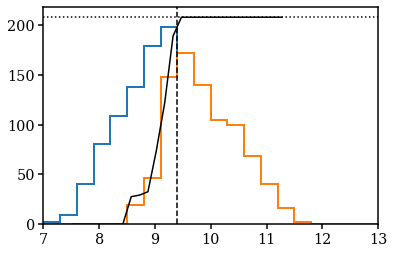

0.025 < z < 0.050


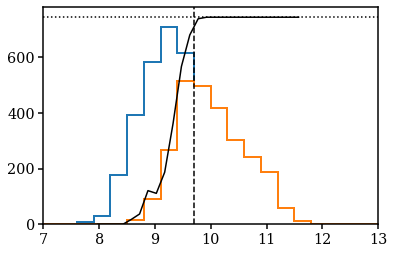

0.050 < z < 0.075


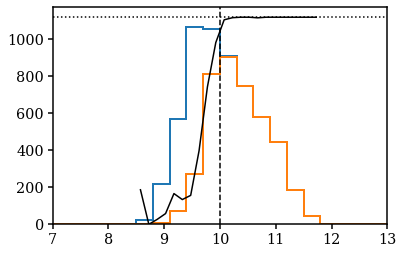

0.075 < z < 0.100


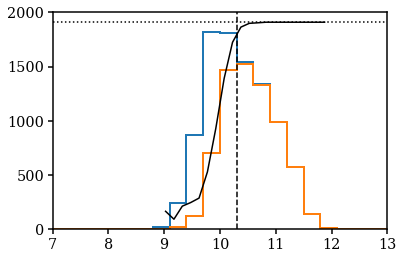

0.100 < z < 0.125


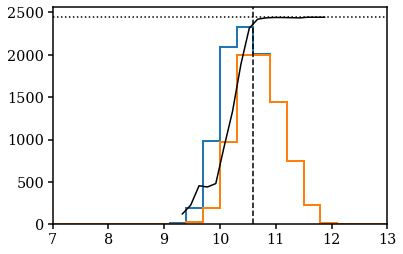

0.125 < z < 0.150


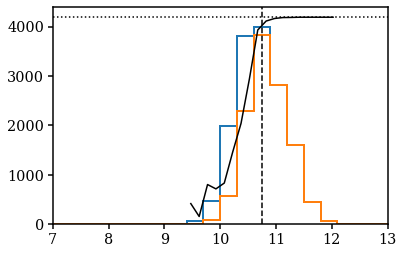

0.150 < z < 0.175


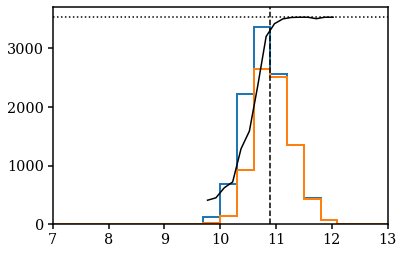

0.175 < z < 0.200


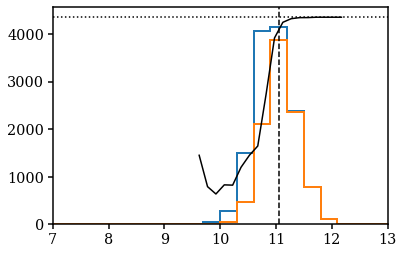

In [11]:
dz = 0.025

Mlims = []
for iz in range(8): 
    print('%.3f < z < %.3f' % (iz * dz, (iz + 1) * dz))
    zlim0 = (bgs['Z'].data > iz * dz) & (bgs['Z'].data < (iz + 1) * dz)

    in_zlim1 = select_z_dz(bgs['theta_bf'].data[zlim0], bgs['Z'].data[zlim0], dz=dz)

    h0, edges = np.histogram(bgs['theta_bf'].data[zlim0,0], range=(7, 13), bins=40)
    h1, _ = np.histogram(bgs['theta_bf'].data[zlim0,0][in_zlim1], range=(7, 13), bins=40)

    fcomp = (h1/h0)
    Mlim = (np.min(edges[:-1][(fcomp > 0.95) & (h0 > 5)]))

    _ = plt.hist(bgs['theta_bf'].data[zlim0,0], range=(7, 13), bins=20, histtype='step', linewidth=2)
    _ = plt.hist(bgs['theta_bf'].data[zlim0,0][in_zlim1], range=(7, 13), bins=20, histtype='step', linewidth=2)
    plt.axvline(Mlim, color='k', linestyle='--') 
    
    ymax = plt.gca().get_ylim()[1]
    plt.plot(0.5*(edges[1:] + edges[:-1])[h0 > 5], (h1/h0)[h0 > 5] * ymax, c='k')
    plt.plot([edges[0], edges[-1]], [ymax, ymax], c='k', ls=':')
    
    plt.xlim(7, 13)
    plt.show()
    
    Mlims.append(Mlim)

In [19]:
is_mass_complete = []
for iz, Mlim in zip(np.arange(8), [Mlims[0]] + Mlims): 
    zlim0 = (bgs['Z'].data > iz * dz) & (bgs['Z'].data < (iz + 1) * dz)
    
    is_mass_complete.append(np.arange(len(bgs))[zlim0][bgs['theta_bf'].data[zlim0,0] > Mlim])
is_mass_complete = np.concatenate(is_mass_complete)

(6.5, 13.0)

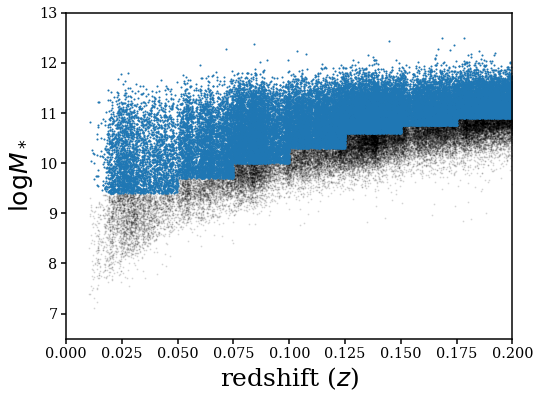

In [21]:
fig = plt.figure(figsize=(8,6))
sub = fig.add_subplot(111)
sub.scatter(bgs['Z'].data, bgs['theta_bf'].data[:,0], c='k', s=1, alpha=0.1)
sub.scatter(bgs['Z'].data[is_mass_complete], bgs['theta_bf'].data[is_mass_complete,0], c='C0', s=1)
sub.set_xlabel(r"redshift ($z$)", fontsize=25)
sub.set_xlim(0., 0.2)
sub.set_ylabel(r"$\log M_*$", fontsize=25)
sub.set_ylim(6.5, 13.)